In [10]:
import seed_data
seed_data.seed()

Seed data complete
Seed data complete


In [43]:
import pandas as pd

# Load the dataset
df = pd.read_csv('pokedex.csv')

# Display first 5 rows to inspect the dataset
df.head()

,name,type1,type2,hp,atk,def,spa,spdef,spd,abilities,heightm,weightkg,color,canEvo,eggGroup1,eggGroup2
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,"[""Overgrow"", ""Chlorophyll""]",0.7,6.9,Green,1,Monster,Grass
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,"[""Overgrow"", ""Chlorophyll""]",1.0,13.0,Green,1,Monster,Grass
2,Venusaur,Grass,Poison,80,82,83,100,100,80,"[""Overgrow"", ""Chlorophyll""]",2.0,100.0,Green,0,Monster,Grass
3,Venusaur-Mega,Grass,Poison,80,100,123,122,120,80,"[""Thick Fat""]",2.4,155.5,Green,0,Monster,Grass
4,Charmander,Fire,NaN,39,52,43,60,50,65,"[""Blaze"", ""Solar Power""]",0.6,8.5,Red,1,Monster,Dragon


In [44]:
from sklearn.preprocessing import MultiLabelBinarizer

# Parse abilities column from string to list
df['abilities'] = df['abilities'].apply(lambda x: eval(x))  # Convert string representation to Python list

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform abilities into binary columns
abilities_encoded = mlb.fit_transform(df['abilities'])

# Convert the binary columns into a DataFrame with ability names as column headers
abilities_df = pd.DataFrame(abilities_encoded, columns=mlb.classes_)

# Concatenate the abilities DataFrame with the original DataFrame
df = pd.concat([df, abilities_df], axis=1)

# Drop the original abilities column, as it is now encoded
df = df.drop('abilities', axis=1)

# Display first few rows to confirm encoding
df.head()


,name,type1,type2,hp,atk,def,spa,spdef,spd,heightm,...,Weak Armor,Well-Baked Body,White Smoke,Wimp Out,Wind Power,Wind Rider,Wonder Guard,Wonder Skin,Zen Mode,Zero to Hero
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,0.7,...,0,0,0,0,0,0,0,0,0,0
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1.0,...,0,0,0,0,0,0,0,0,0,0
2,Venusaur,Grass,Poison,80,82,83,100,100,80,2.0,...,0,0,0,0,0,0,0,0,0,0
3,Venusaur-Mega,Grass,Poison,80,100,123,122,120,80,2.4,...,0,0,0,0,0,0,0,0,0,0
4,Charmander,Fire,NaN,39,52,43,60,50,65,0.6,...,0,0,0,0,0,0,0,0,0,0


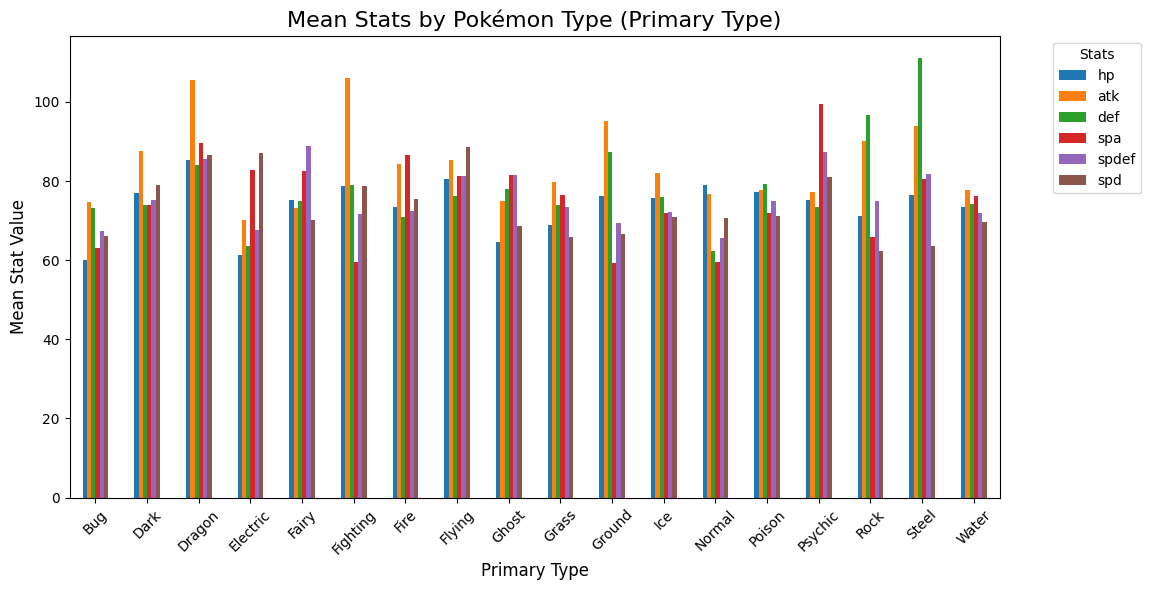

In [28]:
# DATA ANALYSIS OF POKEMON TYPES BASE STATS
import matplotlib.pyplot as plt

numeric_columns = ['hp', 'atk', 'def', 'spa', 'spdef', 'spd']

# Group by the 'type1' (primary type) and calculate the mean of numeric stats
mean_stats = df.groupby('type1')[numeric_columns].mean()
# Plot mean stats by type
fig, ax = plt.subplots(figsize=(12, 6))
mean_stats.plot(kind='bar', ax=ax)

# Add title and labels
ax.set_title('Mean Stats by Pokémon Type (Primary Type)', fontsize=16)
ax.set_xlabel('Primary Type', fontsize=12)
ax.set_ylabel('Mean Stat Value', fontsize=12)
ax.legend(title='Stats', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.show()


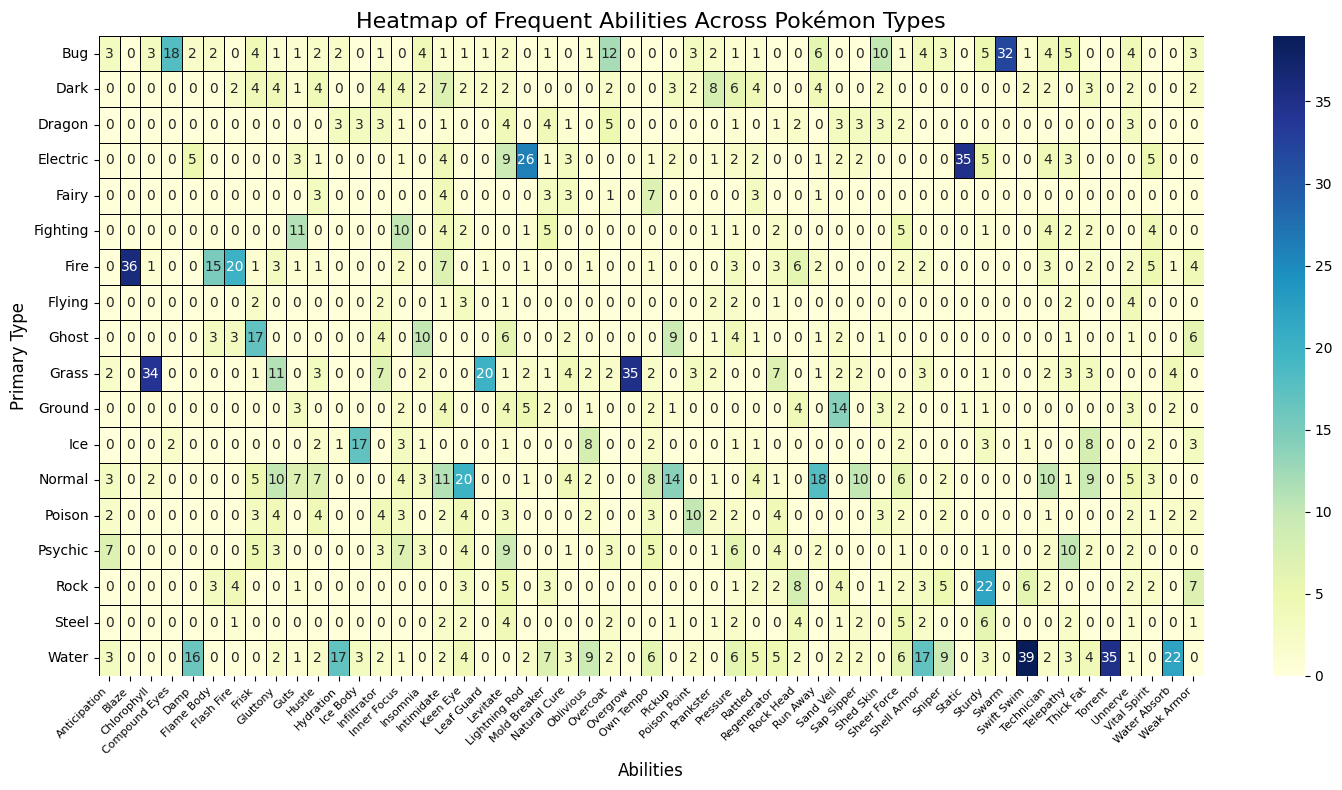

In [22]:
# HEATMAP OF FREQUENT ABILITIES ACROSS POKEMON TYPES
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Filter abilities with high frequency (optional threshold)
# We keep abilities that appear in at least 10 Pokémon to reduce clutter.
ability_sums = df[mlb.classes_].sum()
frequent_abilities = ability_sums[ability_sums >= 20].index  # Filter out rare abilities

# Step 2: Group by 'type1' and sum binary ability columns, then filter frequent abilities
abilities_by_type = df.groupby('type1').sum()[frequent_abilities]

# Step 3: Create the heatmap using seaborn
plt.figure(figsize=(15, 8))
sns.heatmap(
    abilities_by_type, 
    cmap='YlGnBu',  # Color scheme
    annot=True,  # Show the actual numbers in each cell
    fmt='d',  # Integer format for annotations
    linewidths=0.5,  # Add grid lines
    linecolor='black'
)

# Step 4: Add title and labels
plt.title('Heatmap of Frequent Abilities Across Pokémon Types', fontsize=16)
plt.xlabel('Abilities', fontsize=12)
plt.ylabel('Primary Type', fontsize=12)

# Adjust tick label size for better readability
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


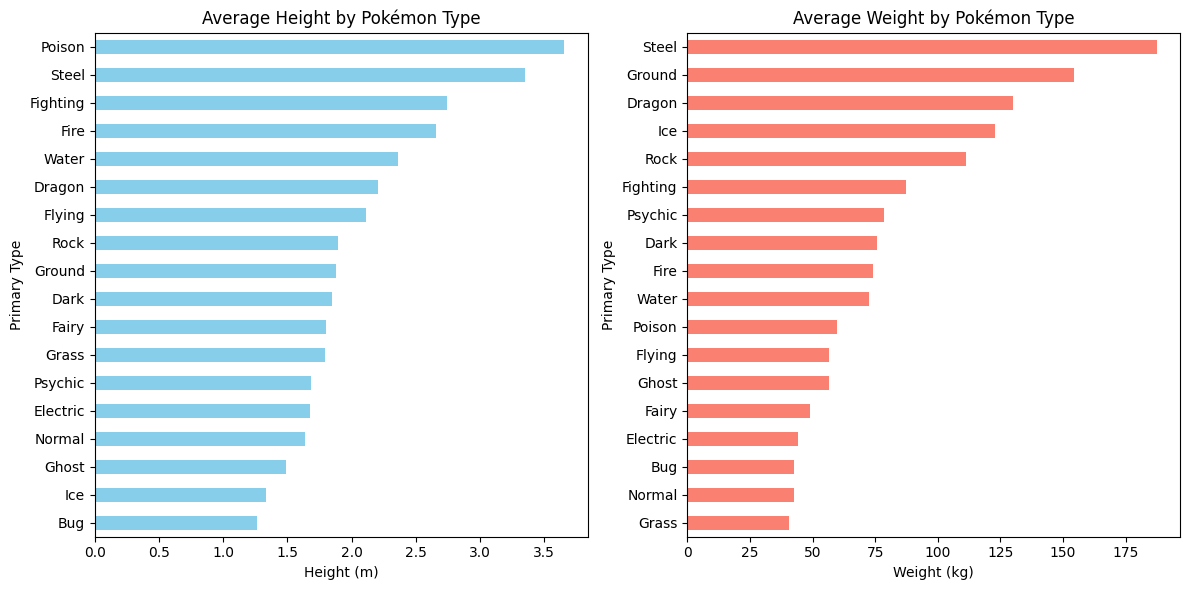

In [32]:
# DATA VISUALIZATION OF HEIGHT AND WEIGHT OF TYPES
import matplotlib.pyplot as plt

height_by_type = df.groupby('type1')['heightm'].mean().sort_values()
weight_by_type = df.groupby('type1')['weightkg'].mean().sort_values()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
height_by_type.plot(kind='barh', color='skyblue')
plt.title('Average Height by Pokémon Type')
plt.xlabel('Height (m)')
plt.ylabel('Primary Type')

plt.subplot(1, 2, 2)
weight_by_type.plot(kind='barh', color='salmon')
plt.title('Average Weight by Pokémon Type')
plt.xlabel('Weight (kg)')
plt.ylabel('Primary Type')

plt.tight_layout()
plt.show()

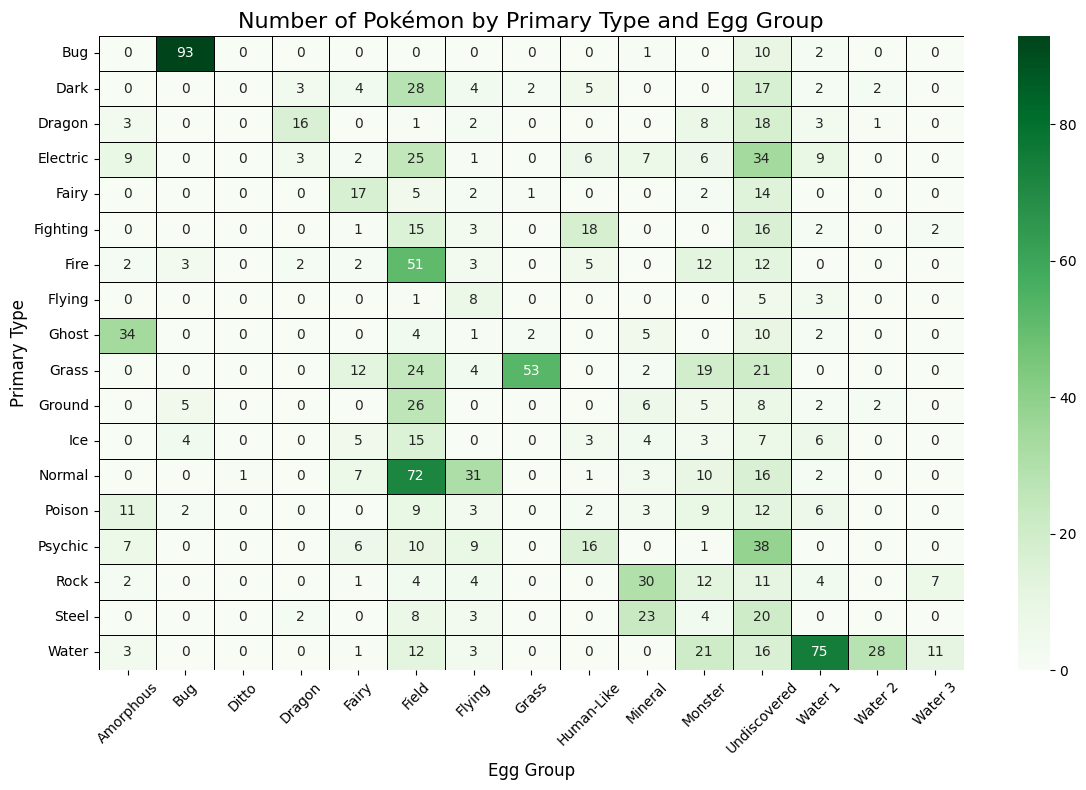

In [42]:
# DATA VISUALIZATION OF RELATIONSHIP BETWEEN EGG GROUPS AND TYPES
import seaborn as sns
import matplotlib.pyplot as plt
egg_group_counts = df.groupby('type1')['eggGroup1'].value_counts().unstack().fillna(0)
secondary_egg_group_counts = df.groupby('type1')['eggGroup2'].value_counts().unstack().fillna(0)
# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(egg_group_counts, cmap='Greens', annot=True, fmt='g', linewidths=0.5, linecolor='black')

# add title and labels
plt.title('Number of Pokémon by Primary Type and Egg Group', fontsize=16)
plt.xlabel('Egg Group', fontsize=12)
plt.ylabel('Primary Type', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

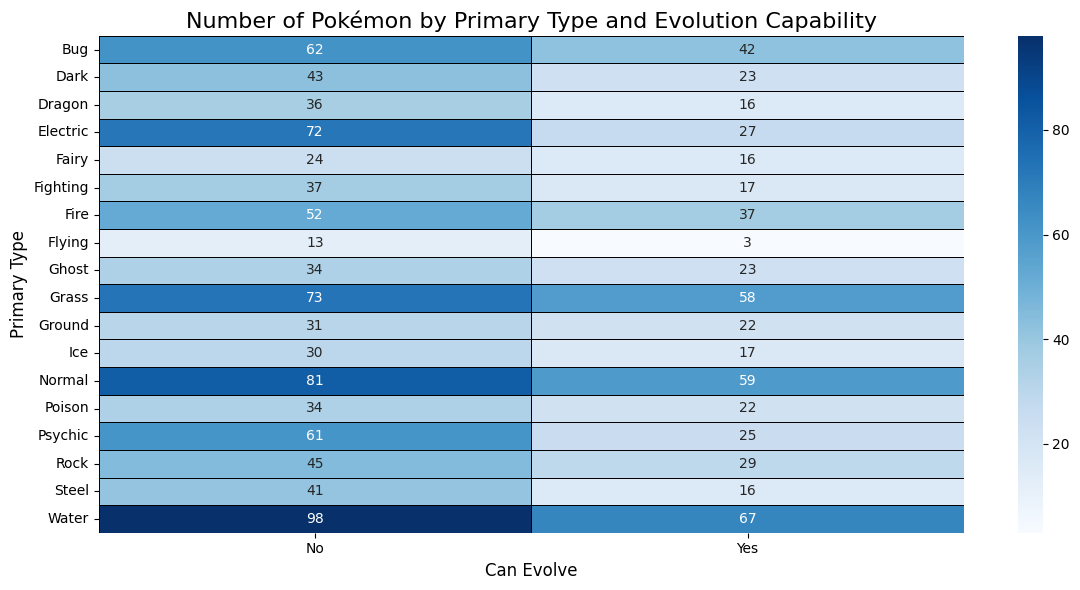

In [49]:
# Data Visualization of RelationShip with canEvo and Types
import seaborn as sns
import matplotlib.pyplot as plt

can_evo_counts = df.groupby('type1')['canEvo'].value_counts().unstack().fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(can_evo_counts, cmap='Blues', annot=True, fmt='g', linewidths=0.5, linecolor='black')

plt.title('Number of Pokémon by Primary Type and Evolution Capability', fontsize=16)
plt.xlabel('Can Evolve', fontsize=12)
plt.ylabel('Primary Type', fontsize=12)

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

In [136]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'type1' column (target variable)
le_type = LabelEncoder()
le_color = LabelEncoder()
le_eggGroup1 = LabelEncoder()
le_eggGroup2 = LabelEncoder()
df['type1_encoded'] = le_type.fit_transform(df['type1'])
print(dict(zip(le_type.classes_, range(len(le_type.classes_)))))
df['color_encoded'] = le_color.fit_transform(df['color'])
print(dict(zip(le_color.classes_, range(len(le_color.classes_)))))
df['eggGroup1_encoded'] = le_eggGroup1.fit_transform(df['eggGroup1'])
print(dict(zip(le_eggGroup1.classes_, range(len(le_eggGroup1.classes_)))))
df['eggGroup2_encoded'] = le_eggGroup2.fit_transform(df['eggGroup2'])
print(dict(zip(le_eggGroup2.classes_, range(len(le_eggGroup2.classes_)))))

{'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}
{'Black': 0, 'Blue': 1, 'Brown': 2, 'Gray': 3, 'Green': 4, 'Pink': 5, 'Purple': 6, 'Red': 7, 'White': 8, 'Yellow': 9}
{'Amorphous': 0, 'Bug': 1, 'Ditto': 2, 'Dragon': 3, 'Fairy': 4, 'Field': 5, 'Flying': 6, 'Grass': 7, 'Human-Like': 8, 'Mineral': 9, 'Monster': 10, 'Undiscovered': 11, 'Water 1': 12, 'Water 2': 13, 'Water 3': 14}
{'Amorphous': 0, 'Bug': 1, 'Dragon': 2, 'Fairy': 3, 'Field': 4, 'Flying': 5, 'Grass': 6, 'Human-Like': 7, 'Mineral': 8, 'Monster': 9, 'Water 1': 10, 'Water 2': 11, 'Water 3': 12, nan: 13}


In [124]:
from sklearn.model_selection import train_test_split

X = df.drop(['type1', 'type1_encoded', 'name','type2','color', 'eggGroup1', 'eggGroup2'], axis=1)
y = df['type1_encoded']
print(X.columns.to_list())

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training Set Size: {X_train.shape}, Test Set Size: {X_test.shape}')


['hp', 'atk', 'def', 'spa', 'spdef', 'spd', 'heightm', 'weightkg', 'canEvo', 'Adaptability', 'Aerilate', 'Aftermath', 'Air Lock', 'Analytic', 'Anger Point', 'Anger Shell', 'Anticipation', 'Arena Trap', 'Armor Tail', 'Aroma Veil', 'As One (Glastrier)', 'As One (Spectrier)', 'Aura Break', 'Bad Dreams', 'Ball Fetch', 'Battery', 'Battle Armor', 'Battle Bond', 'Beads of Ruin', 'Beast Boost', 'Berserk', 'Big Pecks', 'Blaze', 'Bulletproof', 'Cheek Pouch', 'Chilling Neigh', 'Chlorophyll', 'Clear Body', 'Cloud Nine', 'Color Change', 'Comatose', 'Commander', 'Competitive', 'Compound Eyes', 'Contrary', 'Corrosion', 'Costar', 'Cotton Down', 'Cud Chew', 'Curious Medicine', 'Cursed Body', 'Cute Charm', 'Damp', 'Dancer', 'Dark Aura', 'Dauntless Shield', 'Dazzling', 'Defeatist', 'Defiant', 'Delta Stream', 'Desolate Land', 'Disguise', 'Download', "Dragon's Maw", 'Drizzle', 'Drought', 'Dry Skin', 'Early Bird', 'Earth Eater', 'Effect Spore', 'Electric Surge', 'Electromorphosis', 'Embody Aspect (Cornersto

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Initialize Random Forest with 100 estimators
# rt = SGDClassifier(loss='perceptron')
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model on the training set
# rf.fit(X_train, y_train)
rf.fit(X_train, y_train)
print('Random Forest Model Trained Successfully!')


Random Forest Model Trained Successfully!


Accuracy: 0.6115107913669064


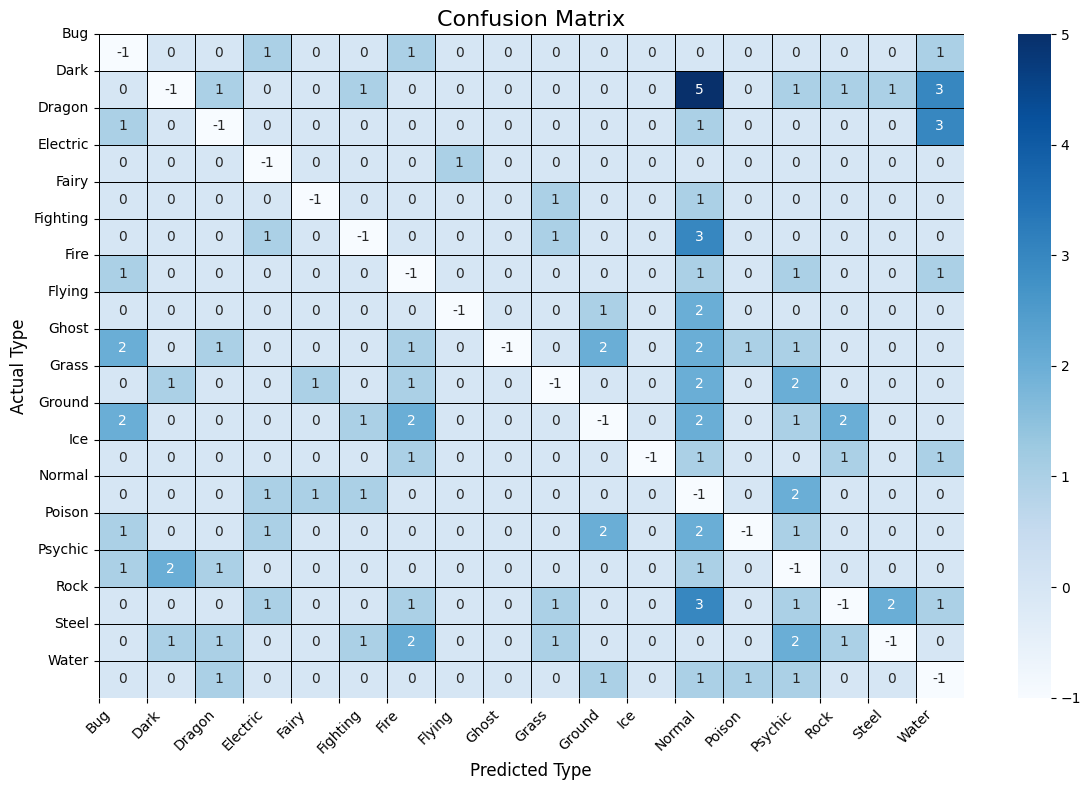

In [142]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
# Predict on the test set
y_pred = rf.predict(X_test)

# Print classification report and accuracy
#print('Classification Report:\n', classification_report(y_test, y_pred, target_names=le.classes_))
print('Accuracy:', accuracy_score(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
# make a cross on the diagonal
for i in range(len(cm)):
    cm[i, i] = -1
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')

# Add title and labels with reconversion to type names
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Type', fontsize=12)
plt.ylabel('Actual Type', fontsize=12)
plt.xticks(ticks=np.arange(len(le_type.classes_)), labels=le_type.classes_, rotation=45)
plt.yticks(ticks=np.arange(len(le_type.classes_)), labels=le_type.classes_, rotation=0)

plt.tight_layout()
plt.show()